In [1]:
# Importing the libraries
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots
plt.style.use('fivethirtyeight')

# !pip yfinance ta
import yfinance as yf
import ta 

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
consider_every_Nth_day = 10 # used in CCI loops only. 10 means biweekly (10 trading days in 2 weeks)
invPerTimePeriod = 1000 / 20 # ration your 1000 per month every day
STOCK = 'SPY'

In [3]:
start="2017-01-01"
start="2003-3-14"
start="2000-01-01"
df = yf.download(STOCK, start) 
# df = df.drop(columns=['Open','High', 'Low','Adj Close','Volume'])
df['MA'] = df.Close.rolling(window=5).mean().fillna(df.Close[0])
df.dropna(inplace=True)
df.head(3)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,MA
Date,,,,,,,
2000-01-03,148.25000,148.25000,143.875000,145.4375,93.881927,8164300,145.4375
2000-01-04,143.53125,144.06250,139.640625,139.7500,90.210564,8089800,145.4375
2000-01-05,139.93750,141.53125,137.250000,140.0000,90.371910,12177900,145.4375


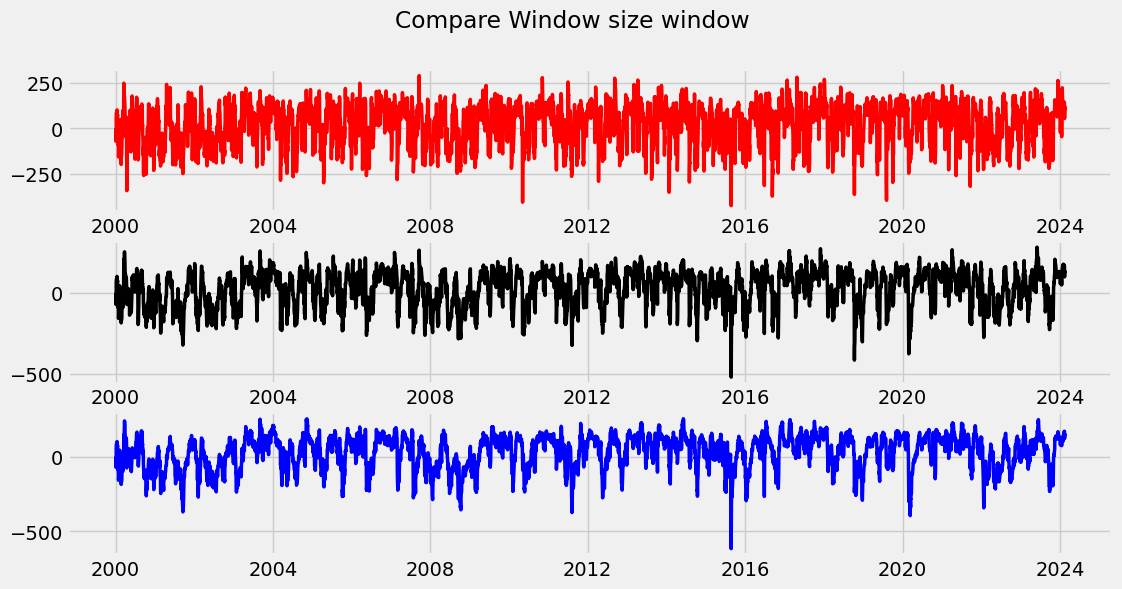

In [4]:
C = 0.015 # 0.015
cci1 = ta.trend.cci(high=df.High, low=df.Low, close=df.Close, window=20, constant=C, fillna=True) # 'n' is now 'window'; 'c' is not 'constant'... damn API changes. current version on ta broke several notebooks. This is why I rerun past code every few years 
cci2 = ta.trend.cci(high=df.High, low=df.Low, close=df.Close, window=40, constant=C, fillna=True)
cci3 = ta.trend.cci(high=df.High, low=df.Low, close=df.Close, window=60, constant=C, fillna=True)


fig, axs = plt.subplots(3, figsize=(12,6))
_=fig.suptitle('Compare Window size window')


_=axs[0].plot(cci1, color='r', linewidth=2.5) #, alpha = 1.0)
_=axs[1].plot(cci2, color='k', linewidth=2.5) #, alpha = 1.0)
_=axs[2].plot(cci3, color='b', linewidth=2.5) #, alpha = 0.85)
plt.show()

In [5]:
df["cci"] = cci3
df.head(5)

,Open,High,Low,Close,Adj Close,Volume,MA,cci
Date,,,,,,,,
2000-01-03,148.25000,148.25000,143.875000,145.4375,93.881927,8164300,145.4375,0.000000
2000-01-04,143.53125,144.06250,139.640625,139.7500,90.210564,8089800,145.4375,-66.666667
2000-01-05,139.93750,141.53125,137.250000,140.0000,90.371910,12177900,145.4375,-71.306413
2000-01-06,139.62500,141.50000,137.750000,137.7500,88.919540,6227200,145.4375,-71.830849
2000-01-07,140.31250,145.75000,140.062500,145.7500,94.083656,8066500,141.7375,55.213825


## Plot days in which the CCI is > N

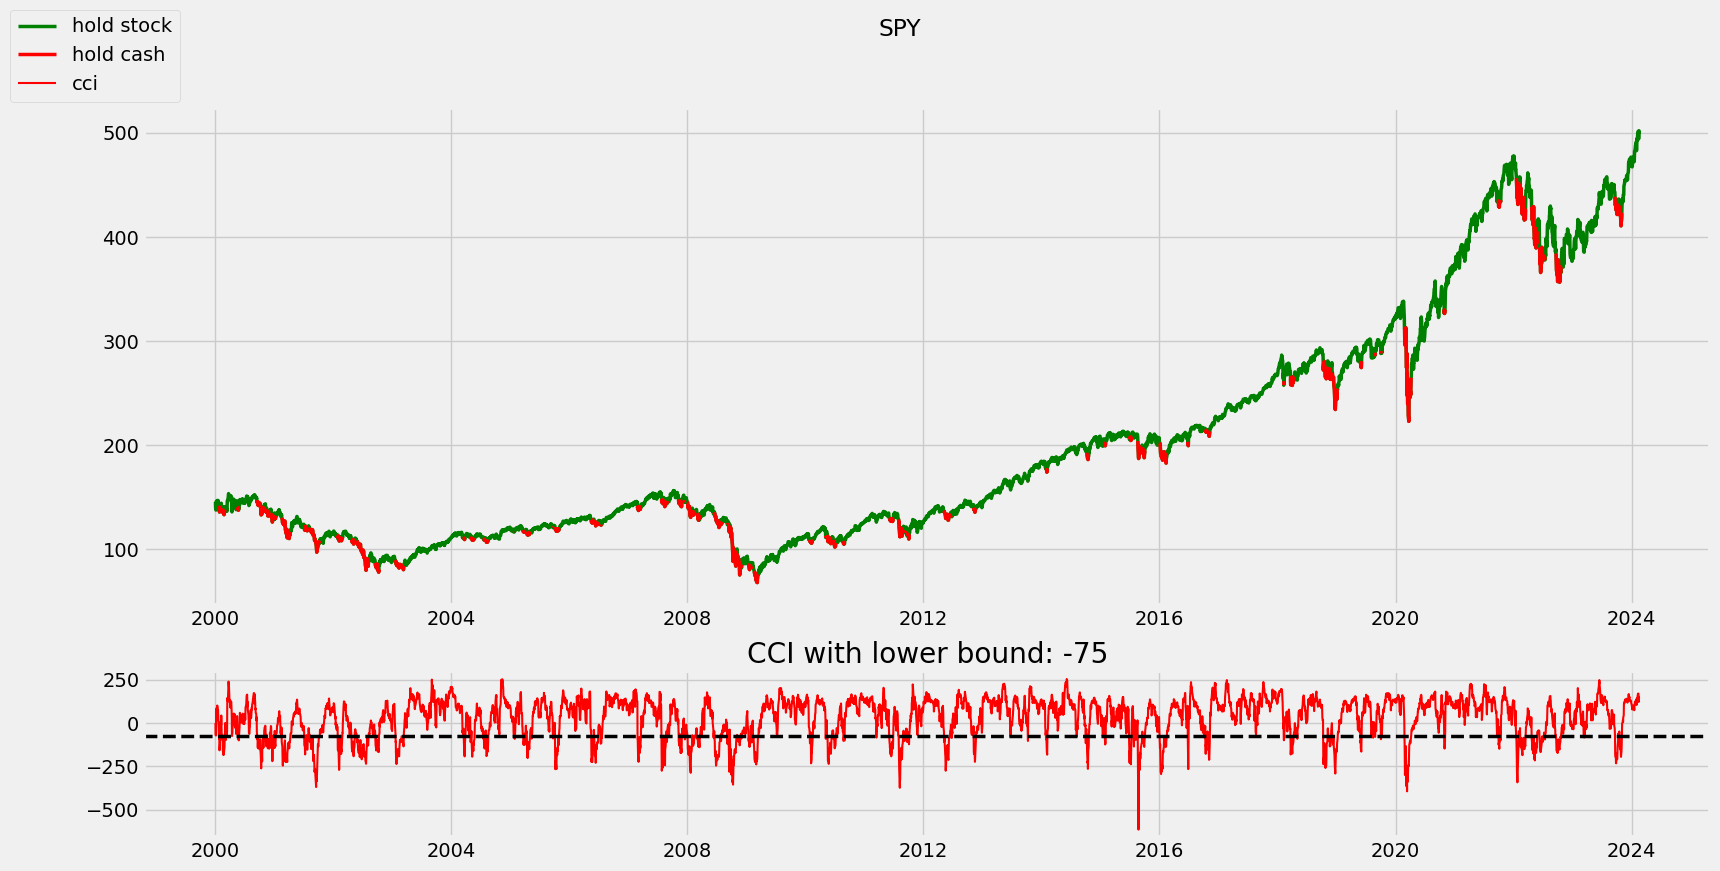

In [6]:
def plot(lowerBound=-100, upperBound=float('inf'), dataset=df):
    #dataset = dataset.copy()
    tmp = dataset[(dataset['cci'] > lowerBound) & (dataset['cci'] < upperBound)]
    a = set(dataset.index.values)
    b = set(tmp.index.values)
    idx_in_market = list(a-b)
    
    dataset['day_not_in_market'] = dataset.loc[idx_in_market].sort_index()['Close']
        
    fig, axs = plt.subplots(2, gridspec_kw={'height_ratios': [3, 1]}) # , figsize=(24, 9)
    fig.suptitle(f"{STOCK.upper()}")
    fig.set_figheight(9)
    fig.set_figwidth(18)
    axs[0].plot(dataset['Close'], color='green', linewidth=2.5, label='hold stock') #, alpha = 1.0)
    axs[0].plot(dataset['day_not_in_market'], color='red', linewidth=2.5, label='hold cash') #, alpha = 1.0)
    axs[1].plot(dataset['cci'], color='red', linewidth=1.5, label='cci') #, alpha = 1.0)
    axs[1].axhline(lowerBound, linewidth=2.5, color="black", linestyle="--")
    if upperBound != float('inf'):
        axs[1].axhline(upperBound, linewidth=2.5, color="black", linestyle="--")
    #set sub title
    axs[1].title.set_text(f"CCI with lower bound: {lowerBound}")

    fig.legend(loc="upper left")

plot(lowerBound=-75)

## Buy and Hold

In [7]:
base_strategy = 0 # Total base strategy
shares = 0 

for i, row in df.iterrows():
    shares += invPerTimePeriod/row.Close
    # print("shares:" , shares)

base_strategy = round(df.tail(1).Close.values[0]*shares, 2)
print(f"Numb of shares: {shares:.2f}")
print(f"Value of Shares: {base_strategy:.2f}")

Numb of shares: 1926.96
Value of Shares: 962535.88


In [8]:
def simulate_stratergy(lower = -100, upper = float('inf'), consider_every_Nth_day=consider_every_Nth_day, useZero=False, quite=False):
    # dataset = df.copy().iloc[0::consider_every_Nth_day]
    dataset = df.iloc[0::consider_every_Nth_day]
    invPerTimePeriod_Nth_day = invPerTimePeriod * consider_every_Nth_day # DAILY $ * N days

    shares = 0 
    cash = 0
    for i in dataset.index:
        cash += invPerTimePeriod_Nth_day
        cci = dataset.loc[i].at['cci']
        close = dataset.loc[i].at['Close']

        if useZero:
            # trade using the zero line
            if cci >= 0:
                # buy
                numb_shares_buying = math.floor(cash/close)
                shares+=numb_shares_buying
                cash -= (close * numb_shares_buying)    
            else:
                cash += (close * shares)
                shares=0

        else:
            # normal way
            if(cci > upper):
    #           # sell
                cash += (close * shares)
                shares=0

            elif(cci <= lower): # or np.isnan(Cci) # prevents exactly "buy and hold" as for the first 40 days (2 iterations) cci is NaN
                # buy 
                numb_shares_buying = math.floor(cash/close)
                shares+=numb_shares_buying
                cash -= (close * numb_shares_buying)
    total = int(dataset.Close[-1]*shares + cash)

    if quite:
        return total    
    print(f"[{lower} to {upper}]\t Made {total:.2f} compared to {base_strategy:.2f}. For a {100*(total-base_strategy)/base_strategy:.4f}% change")

simulate_stratergy(lower = -100, upper = 0)
simulate_stratergy(lower = -100, upper = 100)
simulate_stratergy(lower = -100, upper = 200)
simulate_stratergy(lower = -50,  upper = 0)
simulate_stratergy(lower = -50,  upper = 100)
simulate_stratergy(lower = -50,  upper = 200)
simulate_stratergy(lower = 0,    upper = 100)
simulate_stratergy(lower = 0,    upper = 200)

print("-----------------")
print("No selling")
simulate_stratergy(lower = -200)
simulate_stratergy(lower = -150)
simulate_stratergy(lower = -75)
simulate_stratergy(lower = -30)
simulate_stratergy(lower = 0)
simulate_stratergy(lower = 150)

print("-----------------")
print("Buy and Sell across CCI=0")
simulate_stratergy(lower = 0, upper = 0, useZero=True)

[-100 to 0]	 Made 433039.00 compared to 962535.88. For a -55.0106% change
[-100 to 100]	 Made 474478.00 compared to 962535.88. For a -50.7054% change
[-100 to 200]	 Made 723717.00 compared to 962535.88. For a -24.8114% change
[-50 to 0]	 Made 431776.00 compared to 962535.88. For a -55.1418% change
[-50 to 100]	 Made 509233.00 compared to 962535.88. For a -47.0946% change
[-50 to 200]	 Made 736208.00 compared to 962535.88. For a -23.5137% change
[0 to 100]	 Made 611383.00 compared to 962535.88. For a -36.4821% change
[0 to 200]	 Made 837578.00 compared to 962535.88. For a -12.9822% change
-----------------
No selling
[-200 to inf]	 Made 916837.00 compared to 962535.88. For a -4.7478% change
[-150 to inf]	 Made 931237.00 compared to 962535.88. For a -3.2517% change
[-75 to inf]	 Made 939085.00 compared to 962535.88. For a -2.4364% change
[-30 to inf]	 Made 943361.00 compared to 962535.88. For a -1.9921% change
[0 to inf]	 Made 947307.00 compared to 962535.88. For a -1.5822% change
[150 t

### Plot..


[-100 to 100]	 Made 474478.00 compared to 962535.88. For a -50.7054% change


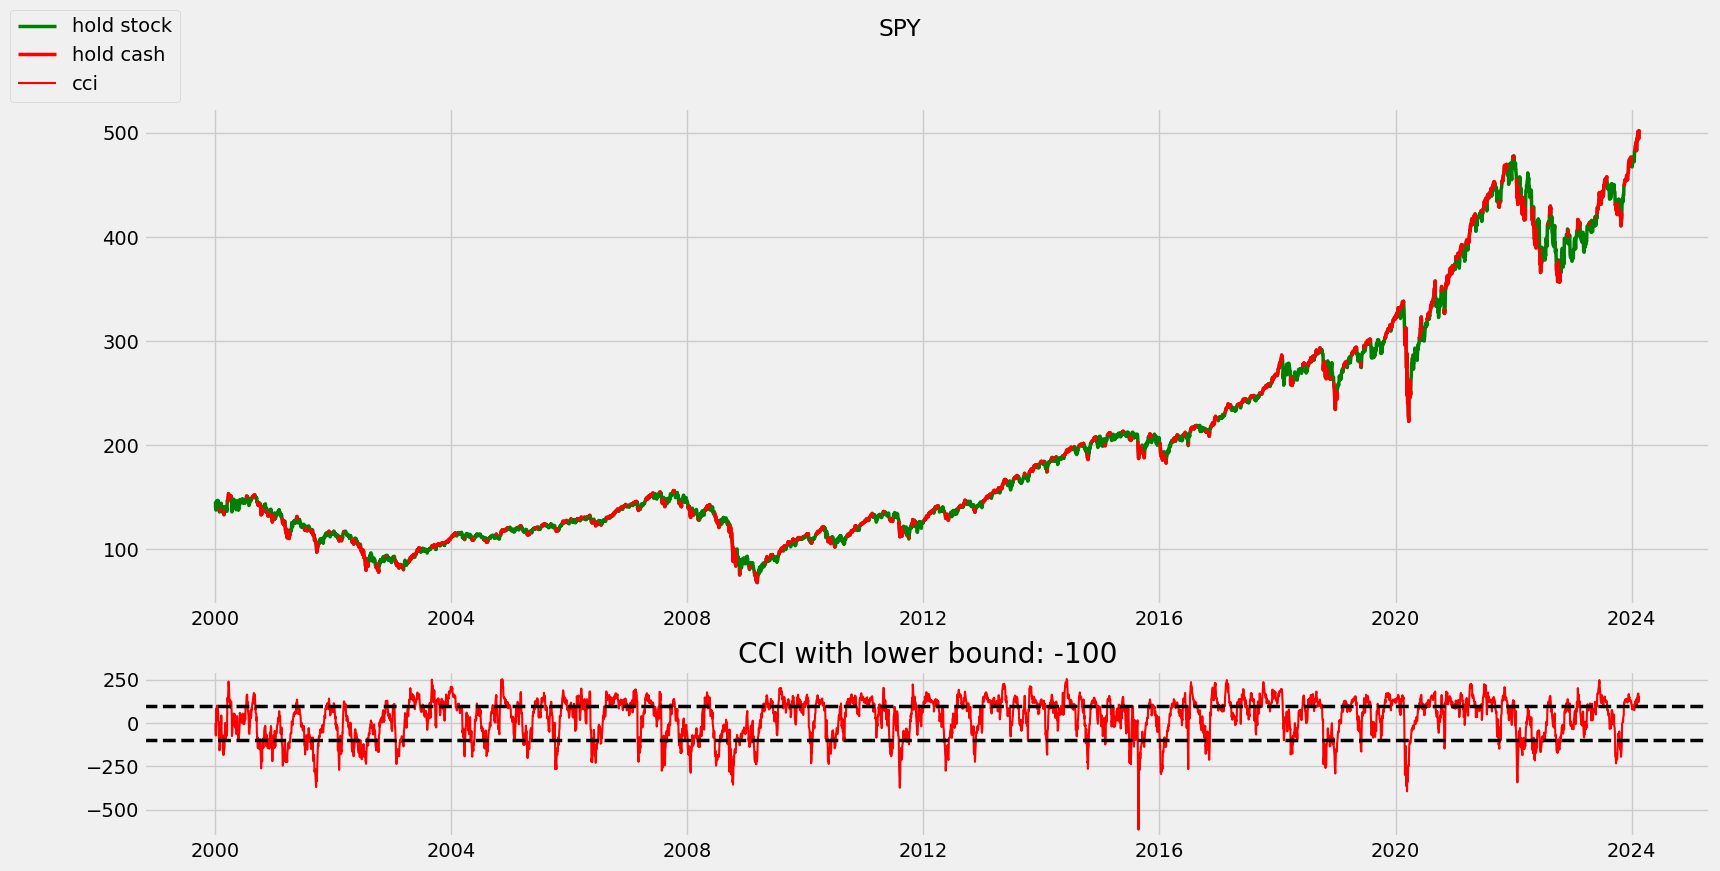

In [9]:
simulate_stratergy(lower = -100, upper=100)
plot(lowerBound=-100, upperBound= 100)

### Optimize the CCI bounds

In [11]:
def find_optimal_range(dataset=df):
  dataset = dataset.iloc[0::consider_every_Nth_day] #[1::20] start at 1, every 20th (monthly)
  
  step_size = 20
  cci_min = int(dataset['cci'].min())
  cci_max = int(dataset['cci'].max())

  top_total = 0
  top_min = 0
  top_max = 0

  for max in np.arange(cci_min, cci_max, step_size): # -200+step_size
    print(f'\nmax is {max} min is ', end="")

    for min in np.arange(cci_min, max, step_size):
        print(f'{min} ', end="")

        total = simulate_stratergy(lower=min, upper=max, consider_every_Nth_day=consider_every_Nth_day, quite=True)

        if(total > top_total):
            top_total = total
            top_min, top_max = min, max 

  print("\n=======================================")
  print(f"[{top_min} to {top_max}]\t Made {total:.2f} compared to {base_strategy:.2f}")
  print(f"For a {100*(total-base_strategy)/base_strategy:.4f}% change")


resultOfCCStrat = find_optimal_range()


max is -342 min is 
max is -322 min is -342 
max is -302 min is -342 -322 
max is -282 min is -342 -322 -302 
max is -262 min is -342 -322 -302 -282 
max is -242 min is -342 -322 -302 -282 -262 
max is -222 min is -342 -322 -302 -282 -262 -242 
max is -202 min is -342 -322 -302 -282 -262 -242 -222 
max is -182 min is -342 -322 -302 -282 -262 -242 -222 -202 
max is -162 min is -342 -322 -302 -282 -262 -242 -222 -202 -182 
max is -142 min is -342 -322 -302 -282 -262 -242 -222 -202 -182 -162 
max is -122 min is -342 -322 -302 -282 -262 -242 -222 -202 -182 -162 -142 
max is -102 min is -342 -322 -302 -282 -262 -242 -222 -202 -182 -162 -142 -122 
max is -82 min is -342 -322 -302 -282 -262 -242 -222 -202 -182 -162 -142 -122 -102 
max is -62 min is -342 -322 -302 -282 -262 -242 -222 -202 -182 -162 -142 -122 -102 -82 
max is -42 min is -342 -322 -302 -282 -262 -242 -222 -202 -182 -162 -142 -122 -102 -82 -62 
max is -22 min is -342 -322 -302 -282 -262 -242 -222 -202 -182 -162 -142 -122 -102 -8